# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
from copy import deepcopy
import pandas as pd
from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS
from src.logging import get_logger
from src.configs import MODELLED_MARKETS

logger = get_logger(__name__)

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
config = "adverse depeg"
scenario_ = Scenario(config, MODELLED_MARKETS)
print(
    f"Running {scenario_.num_steps} steps with frequency {scenario_.pricepaths.config['freq']}."
)

[INFO][14:42:25][src.sim.scenario]-8518: Fetching wbtc market from subgraph
[INFO][14:42:31][src.sim.scenario]-8518: Market snapshot as 2024-01-16 22:24:59
[INFO][14:42:31][src.sim.scenario]-8518: Bands snapshot as 2024-01-15 19:58:47
[INFO][14:42:31][src.sim.scenario]-8518: Users snapshot as 2024-01-16 23:17:47
[INFO][14:42:31][src.sim.scenario]-8518: Fetching weth market from subgraph
[INFO][14:42:37][src.sim.scenario]-8518: Market snapshot as 2024-01-16 22:24:59
[INFO][14:42:37][src.sim.scenario]-8518: Bands snapshot as 2024-01-15 19:58:47
[INFO][14:42:37][src.sim.scenario]-8518: Users snapshot as 2024-01-16 23:17:47
[INFO][14:42:37][src.sim.scenario]-8518: Fetching sfrxeth market from subgraph
[INFO][14:42:43][src.sim.scenario]-8518: Market snapshot as 2024-01-16 22:24:59
[INFO][14:42:43][src.sim.scenario]-8518: Bands snapshot as 2024-01-15 19:58:47
[INFO][14:42:43][src.sim.scenario]-8518: Users snapshot as 2024-01-16 23:17:47
[INFO][14:42:43][src.sim.scenario]-8518: Fetching wstet

Running 288 steps with frequency 5min.


In [6]:
scenario = deepcopy(scenario_)
scenario.prepare_for_run(resample=True)

In [7]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)

In [8]:
import cProfile
import pstats

with cProfile.Profile() as pr:
    for sample in scenario.pricepaths:
        # print(sample.timestamp.time())
        scenario.prepare_for_trades(sample)  # update prices/timestamps
        scenario.perform_actions(sample)  # arbitrage, liquidate, update
        processor.update(sample.timestamp, inplace=True)  # collect metrics

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.CUMULATIVE)
stats.print_stats()

         212703972 function calls (212571447 primitive calls) in 85.884 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      288    0.001    0.000   72.611    0.252 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/sim/scenario.py:565(perform_actions)
      288    0.003    0.000   64.384    0.224 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:31(arbitrage)
      772    0.078    0.000   64.320    0.083 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/agents/arbitrageur.py:75(find_best_arbitrage)
    43232    0.078    0.000   64.144    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:139(optimize)
    37364    0.133    0.000   51.139    0.001 /Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/trades/cycle.py:271(_optimize_mem)
    32479    0.181    0.000   50.092    0.002 /Users/tncintra/Desk

In [9]:
results = processor.process()

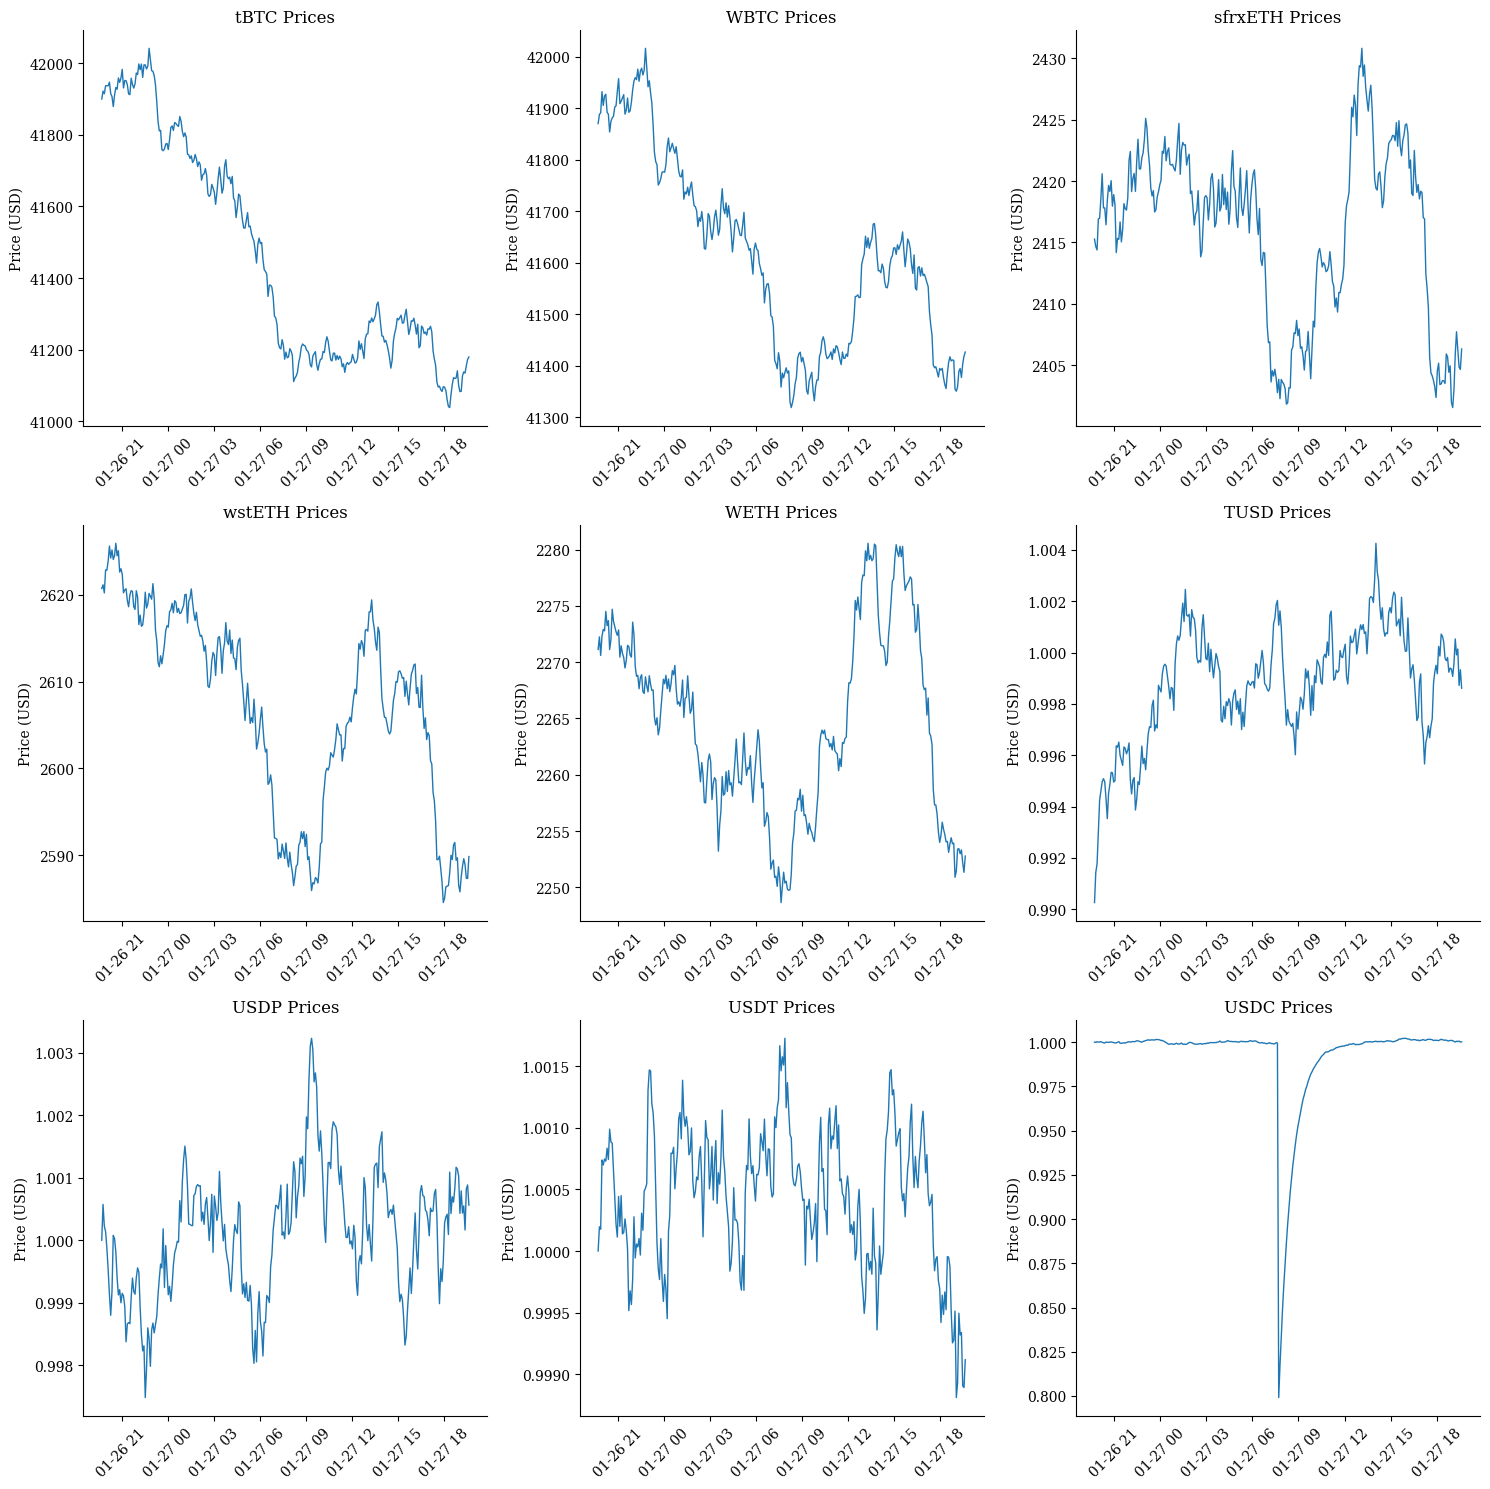

In [12]:
results.plot_prices()

In [13]:
df = results.df
# df.to_csv("../data/results.csv")
df.tail()

,Bad Debt Pct,Bad Debt Pct on Controller Wbtc,Bad Debt Pct on Controller Weth,Bad Debt Pct on Controller Sfrxeth,Bad Debt Pct on Controller Wsteth,System Health,System Health on Controller Wbtc,System Health on Controller Weth,System Health on Controller Sfrxeth,System Health on Controller Wsteth,Borrower Loss Pct,Hard Liquidation Loss Pct,Soft Liquidation Loss Pct,Value Leakage,Keeper Profit,Keeper Count,Keeper Profit on Pk Crvusd/Tusd,Keeper Count on Pk Crvusd/Tusd,Keeper Profit on Pk Crvusd/Usdp,Keeper Count on Pk Crvusd/Usdp,Keeper Profit on Pk Crvusd/Usdc,Keeper Count on Pk Crvusd/Usdc,Keeper Profit on Pk Crvusd/Usdt,Keeper Count on Pk Crvusd/Usdt,Liquidator Profit,Liquidator Count,Liquidator Profit on Controller Wbtc,Liquidator Count on Controller Wbtc,Liquidator Profit on Controller Weth,Liquidator Count on Controller Weth,Liquidator Profit on Controller Sfrxeth,Liquidator Count on Controller Sfrxeth,Liquidator Profit on Controller Wsteth,Liquidator Count on Controller Wsteth,Arbitrageur Profit,Arbitrageur Count,Aggregator Price,Stableswap Crvusd_Tusd Price,Stableswap Crvusd_Usdp Price,Stableswap Crvusd_Usdc Price,Stableswap Crvusd_Usdt Price,Debt Liquidated Pct,Debt Liquidated Pct on Controller Wbtc,Debt Liquidated Pct on Controller Weth,Debt Liquidated Pct on Controller Sfrxeth,Debt Liquidated Pct on Controller Wsteth,PK Debt,Pk Crvusd/Tusd Debt,Pk Crvusd/Usdp Debt,Pk Crvusd/Usdc Debt,Pk Crvusd/Usdt Debt,Total crvUSD Liquidity,Stableswap Crvusd_Tusd crvUSD Liquidity,Stableswap Crvusd_Usdp crvUSD Liquidity,Stableswap Crvusd_Usdc crvUSD Liquidity,Stableswap Crvusd_Usdt crvUSD Liquidity,Total Debt,Controller Wbtc Total Debt,Controller Weth Total Debt,Controller Sfrxeth Total Debt,Controller Wsteth Total Debt,Worst Oracle Error Pct,Llamma Wbtc Oracle Price,Llamma Wbtc Oracle Error Pct,Llamma Weth Oracle Price,Llamma Weth Oracle Error Pct,Llamma Sfrxeth Oracle Price,Llamma Sfrxeth Oracle Error Pct,Llamma Wsteth Oracle Price,Llamma Wsteth Oracle Error Pct,Tricrypto Usdt Oracle Price WBTC,Tricrypto Usdt Oracle Price WETH,Tricrypto Usdc Oracle Price WBTC,Tricrypto Usdc Oracle Price WETH,Net LLAMMA Profit Pct,LLAMMA Profit on Llamma Wbtc Pct,LLAMMA Profit on Llamma Weth Pct,LLAMMA Profit on Llamma Sfrxeth Pct,LLAMMA Profit on Llamma Wsteth Pct
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-27 19:17:47,0.000351,0.0,0.0,0.0,0.000896,0.769106,0.841370,0.793801,0.879725,0.663963,0.020021,0.006564,0.013457,2.712380e+06,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,28247.733653,4,20055.338503,2,7651.057962,1,0.0,0,541.337188,1,2.684133e+06,483,0.999317,0.999609,0.999046,0.998867,0.999926,0.123617,0.201047,0.32767,0.0,0.010652,1.186605e+07,4.939855e+06,0.0,0.0,6.926199e+06,4.656854e+07,4.304120e+06,2.601010e+06,2.443149e+07,1.523192e+07,1.010539e+08,3.775558e+07,1.362518e+07,1.000128e+07,3.967189e+07,0.000079,41394.320696,0.000079,2252.989183,0.000079,2407.711830,0.000079,2589.596425,0.000079,41422.510003,2254.523456,41370.939130,2251.716583,0.004648,0.011679,0.001726,0.0,0.000124
2024-01-27 19:22:47,0.000351,0.0,0.0,0.0,0.000896,0.768666,0.840688,0.794227,0.878640,0.663619,0.020021,0.006564,0.013457,2.712380e+06,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,28247.733653,4,20055.338503,2,7651.057962,1,0.0,0,541.337188,1,2.684133e+06,483,0.999317,0.999609,0.999046,0.998867,0.999926,0.123617,0.201047,0.32767,0.0,0.010652,1.186605e+07,4.939855e+06,0.0,0.0,6.926199e+06,4.656854e+07,4.304120e+06,2.601010e+06,2.443149e+07,1.523192e+07,1.010540e+08,3.775559e+07,1.362518e+07,1.000128e+07,3.967191e+07,0.007179,41379.944621,0.007179,2253.492151,0.007179,2406.404087,0.007179,2589.098142,0.007179,41404.347232,2254.821082,41361.436762,2252.484240,0.004648,0.011679,0.001726,0.0,0.000124
2024-01-27 19:27:47,0.000351,0.0,0.0,0.0,0.000896,0.768660,0.842138,0.793450,0.877690,0.662731,0.020021,0.006564,0.013457,2.712430e+06,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,28247.733653,4,20055.338503,2,7651.057962,1,0.0,0,541.337188,1,2.684183e+06,484,0.

In [14]:
results.metric_map

{'BadDebtMetric': 0,
 'SystemHealthMetric': 1,
 'BorrowerLossMetric': 2,
 'ValueLeakageMetric': 3,
 'PegStrengthMetric': 4,
 'LiquidationsMetric': 5,
 'PegKeeperMetric': 6,
 'LiquidityMetric': 7,
 'DebtMetric': 8,
 'PriceMetric': 9,
 'ProfitsMetric': 10}

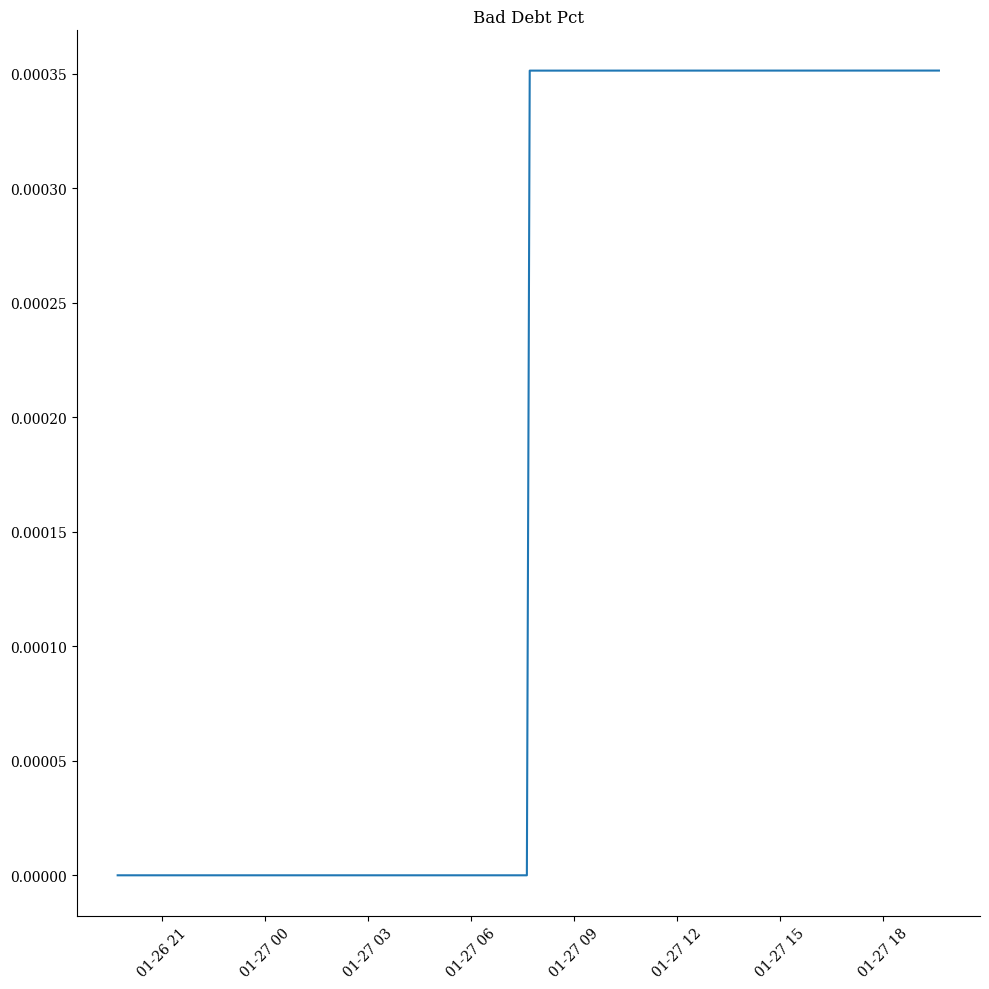

<Axes: title={'center': 'Bad Debt Pct'}>

In [15]:
results.plot_metric(0, show=True)

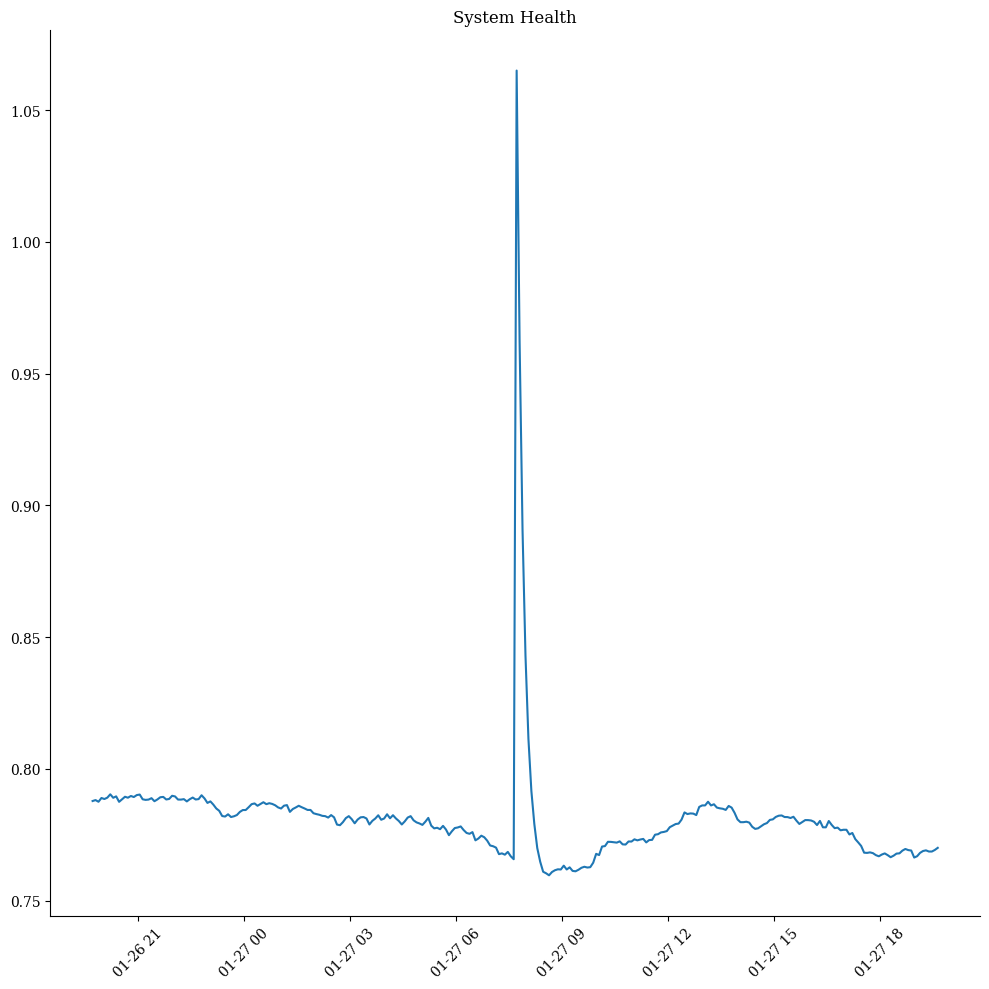

<Axes: title={'center': 'System Health'}>

In [16]:
results.plot_metric(1, show=True)

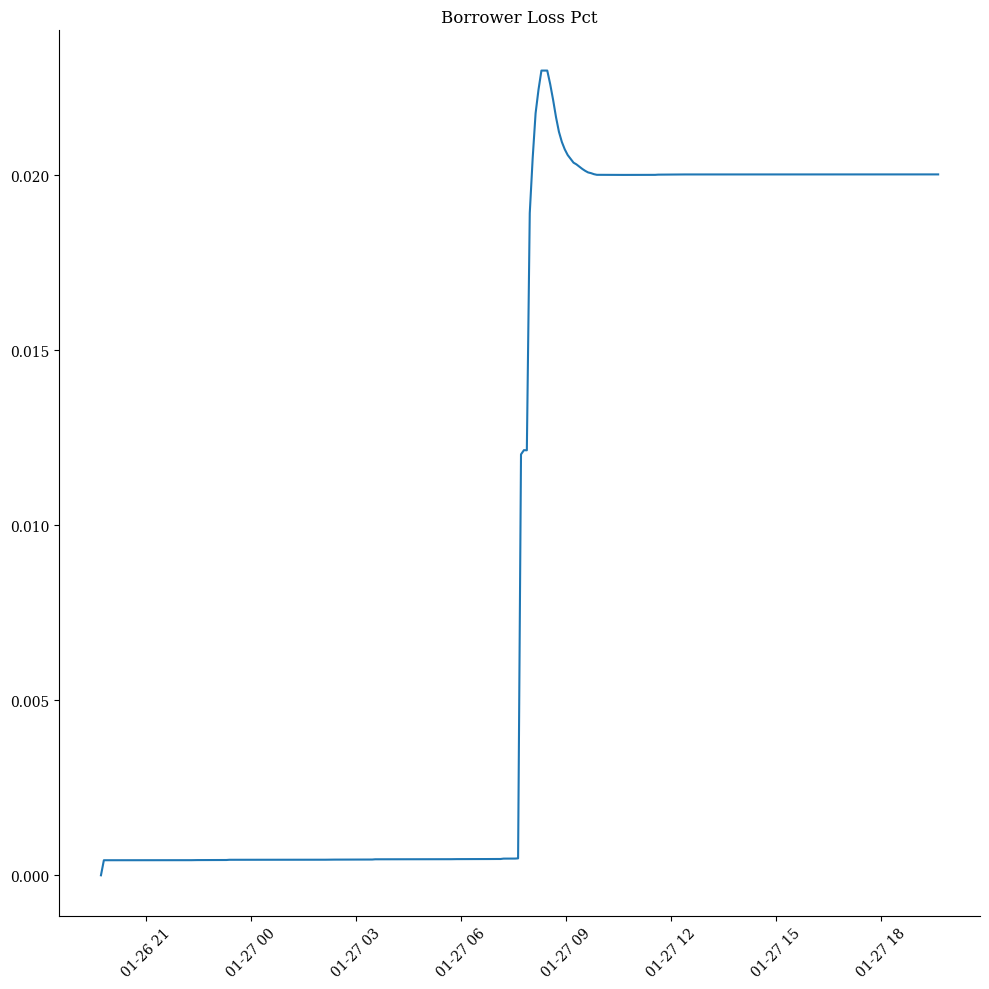

<Axes: title={'center': 'Borrower Loss Pct'}>

In [17]:
results.plot_metric(2, show=True)

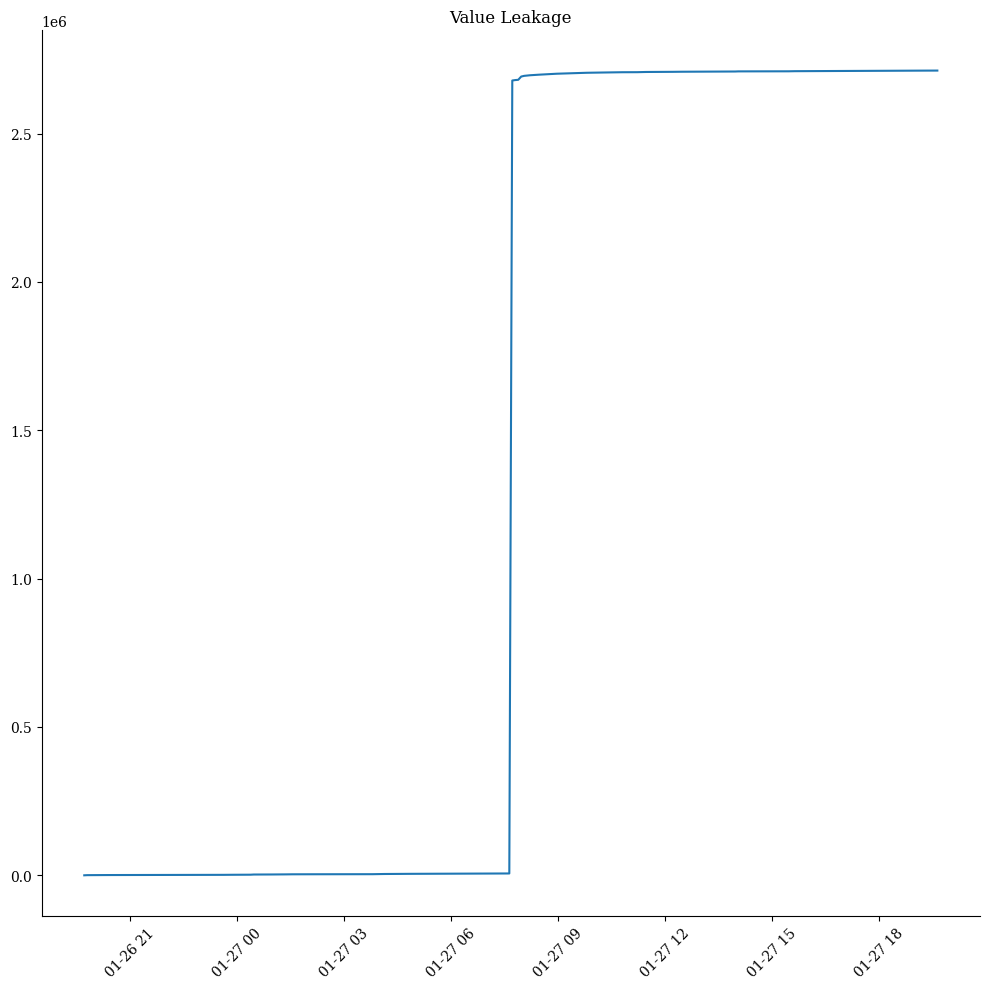

<Axes: title={'center': 'Value Leakage'}>

In [18]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

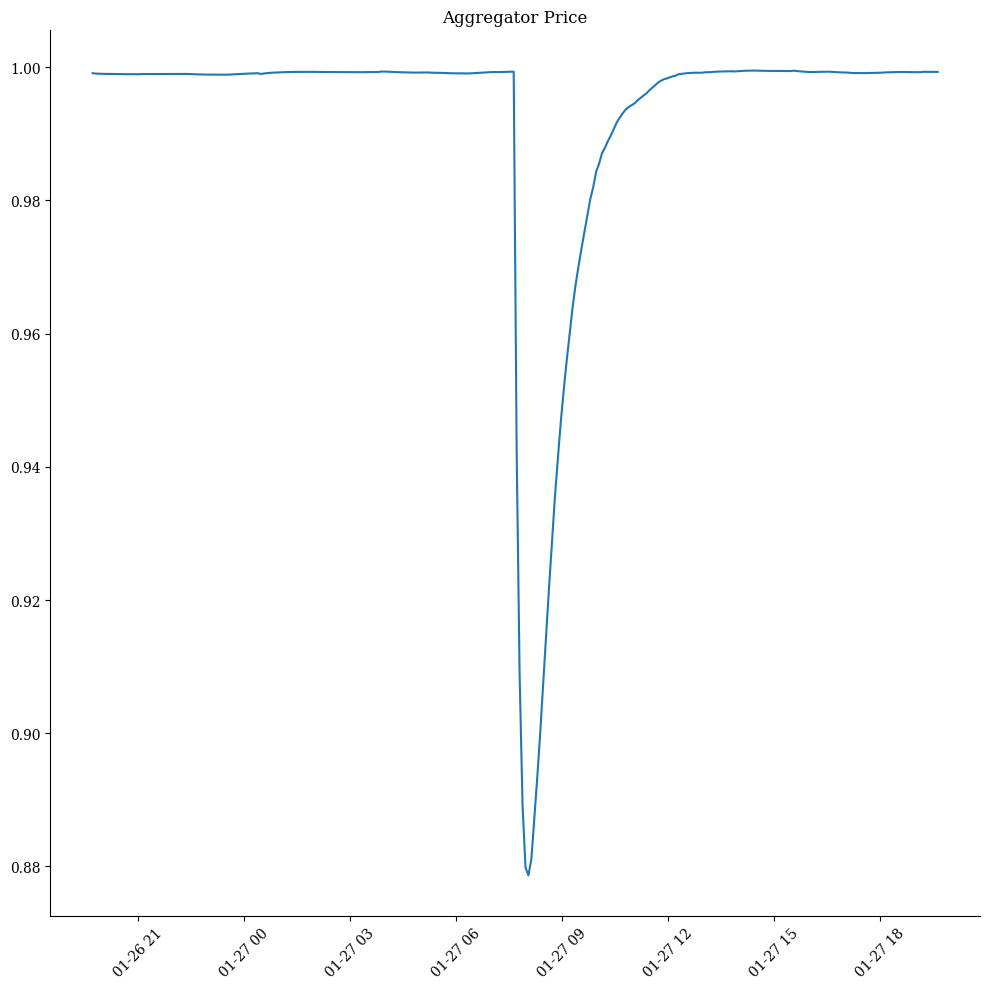

<Axes: title={'center': 'Aggregator Price'}>

In [19]:
results.plot_metric(4, show=True)

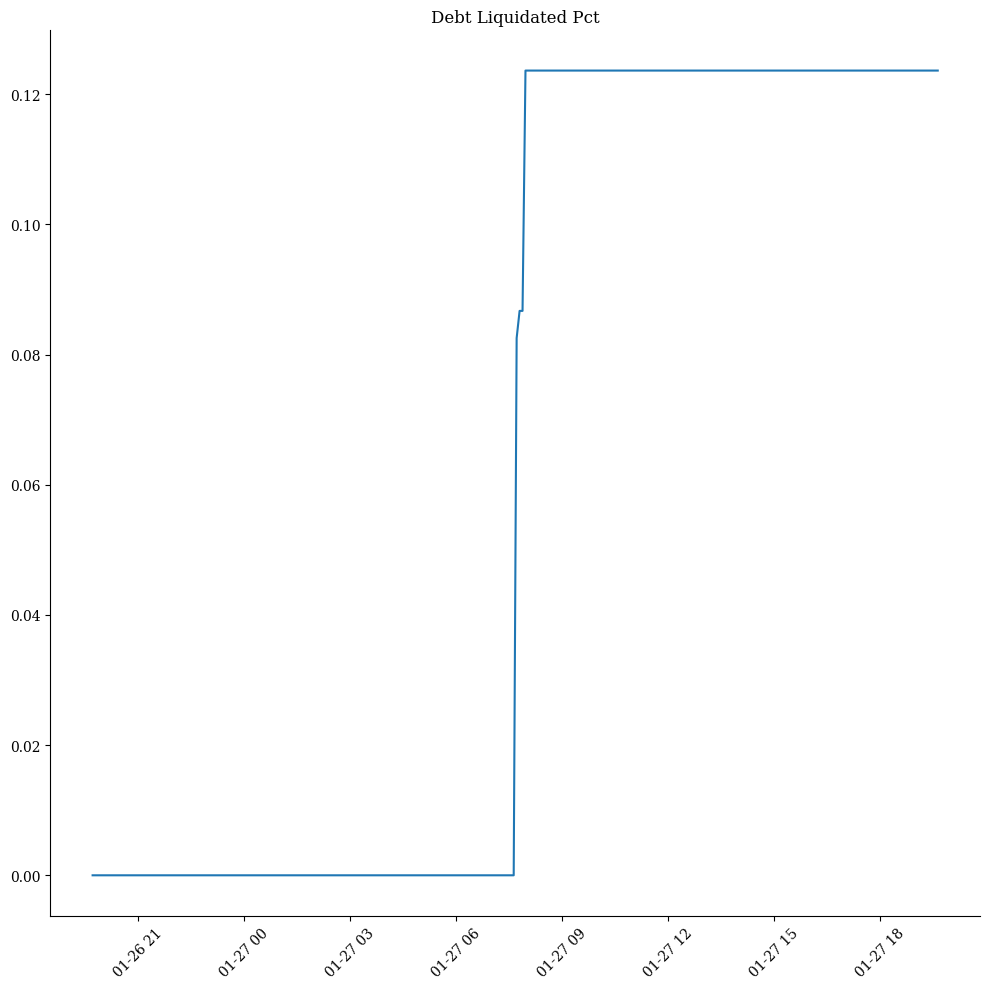

<Axes: title={'center': 'Debt Liquidated Pct'}>

In [20]:
results.plot_metric(5, show=True)

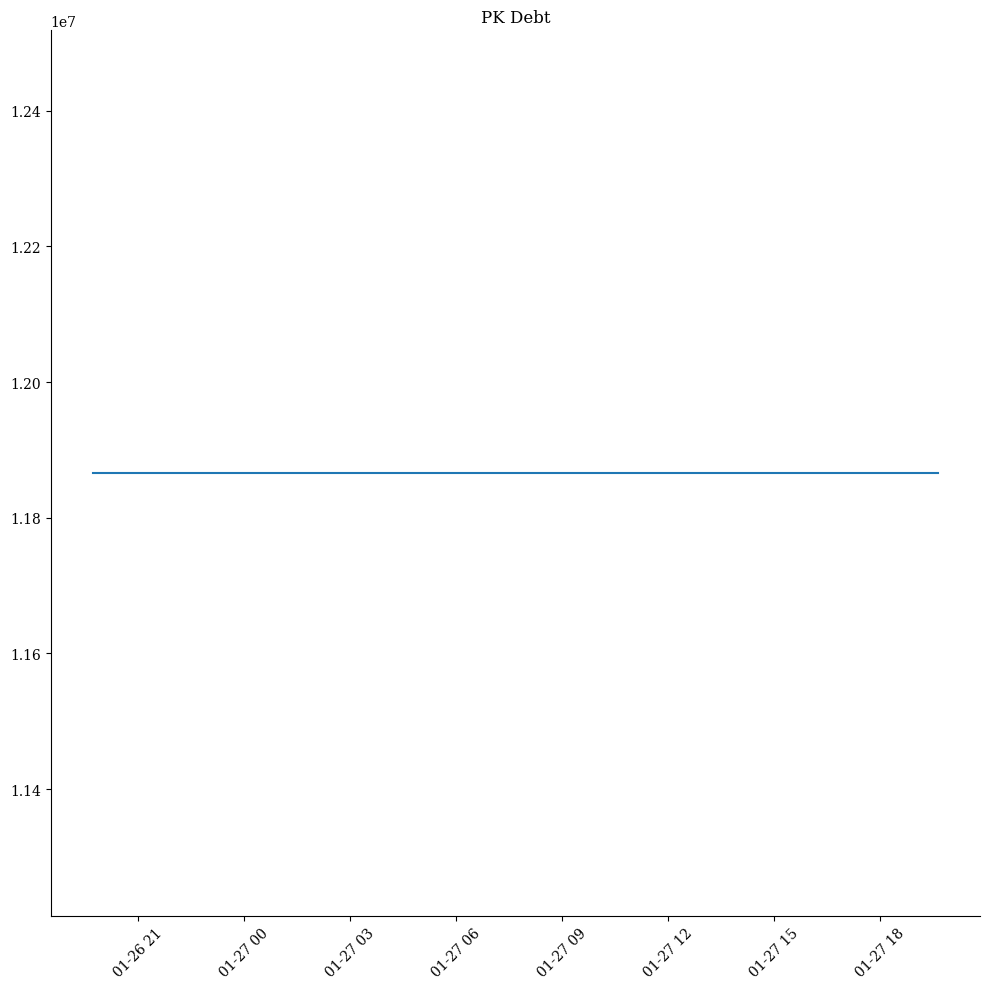

<Axes: title={'center': 'PK Debt'}>

In [21]:
results.plot_metric(6, show=True)

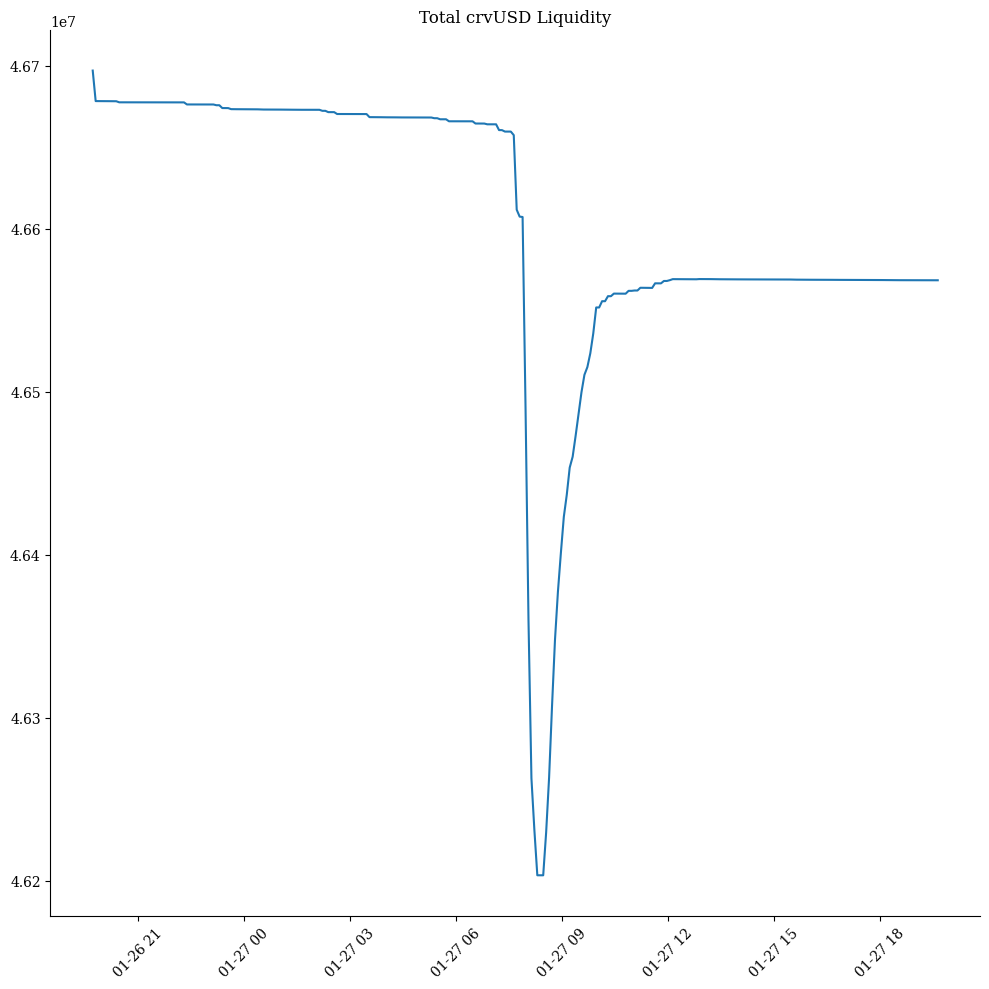

<Axes: title={'center': 'Total crvUSD Liquidity'}>

In [22]:
results.plot_metric(7, show=True)

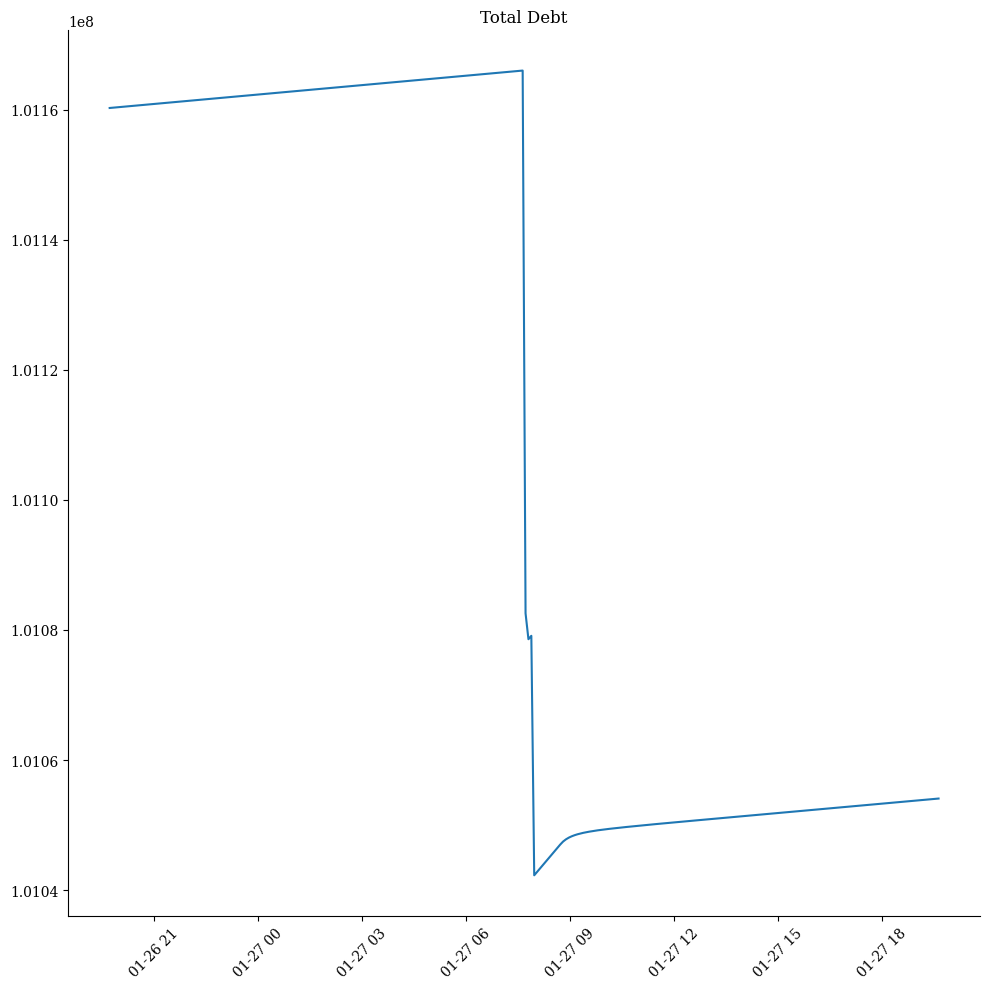

<Axes: title={'center': 'Total Debt'}>

In [23]:
results.plot_metric(8, show=True)

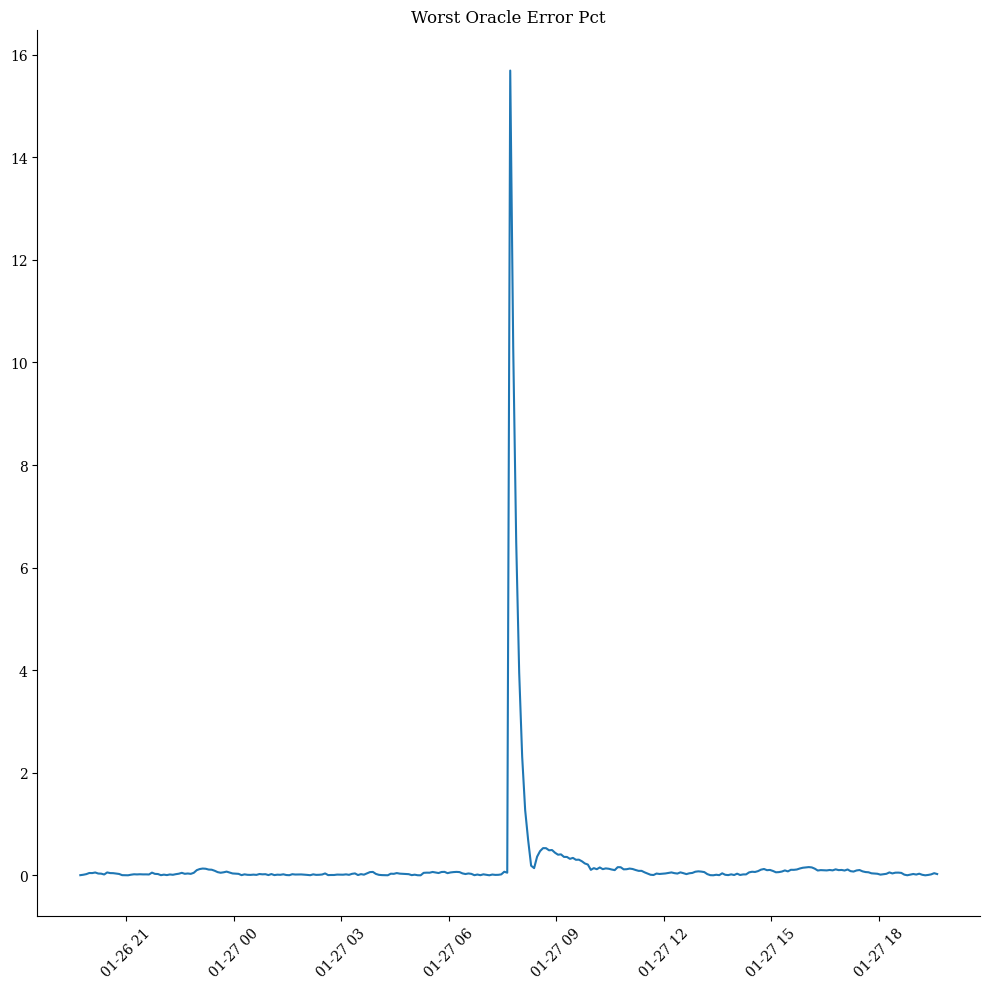

<Axes: title={'center': 'Worst Oracle Error Pct'}>

In [24]:
results.plot_metric(9, show=True)

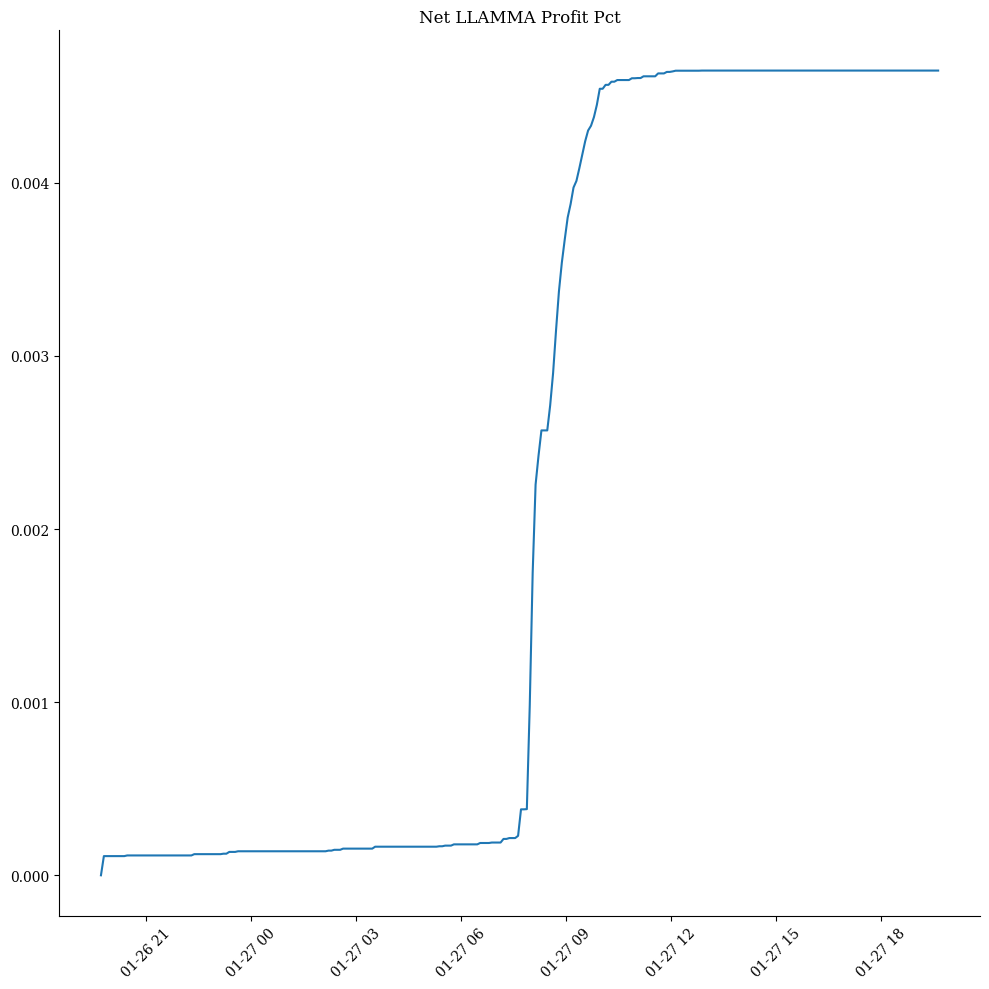

<Axes: title={'center': 'Net LLAMMA Profit Pct'}>

In [25]:
results.plot_metric(10, show=True)

In [26]:
for llamma in scenario.llammas:
    print(
        llamma.name,
        sum(llamma.bands_fees_x.values()),
        sum(llamma.bands_fees_y.values()),
    )

Curve.fi Stablecoin WBTC 2587591491725949778709 51655497840000000
Curve.fi Stablecoin WETH 139953195189890381869 43150180143216317
Curve.fi Stablecoin sfrxETH 0 0
Curve.fi Stablecoin wstETH 28872511770985308502 8451526762387630


<Axes: xlabel='timestamp'>

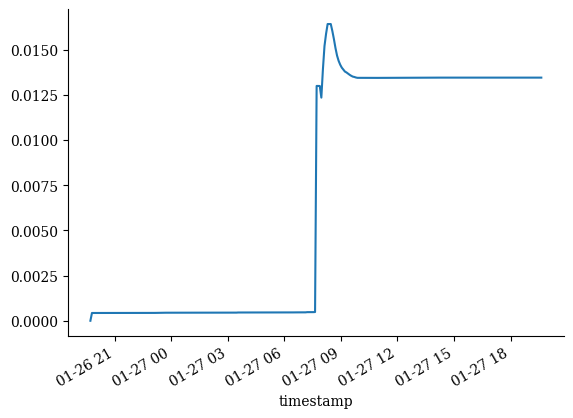

In [27]:
results.df["Soft Liquidation Loss Pct"].plot()

In [28]:
results.df

,Bad Debt Pct,Bad Debt Pct on Controller Wbtc,Bad Debt Pct on Controller Weth,Bad Debt Pct on Controller Sfrxeth,Bad Debt Pct on Controller Wsteth,System Health,System Health on Controller Wbtc,System Health on Controller Weth,System Health on Controller Sfrxeth,System Health on Controller Wsteth,Borrower Loss Pct,Hard Liquidation Loss Pct,Soft Liquidation Loss Pct,Value Leakage,Keeper Profit,Keeper Count,Keeper Profit on Pk Crvusd/Tusd,Keeper Count on Pk Crvusd/Tusd,Keeper Profit on Pk Crvusd/Usdp,Keeper Count on Pk Crvusd/Usdp,Keeper Profit on Pk Crvusd/Usdc,Keeper Count on Pk Crvusd/Usdc,Keeper Profit on Pk Crvusd/Usdt,Keeper Count on Pk Crvusd/Usdt,Liquidator Profit,Liquidator Count,Liquidator Profit on Controller Wbtc,Liquidator Count on Controller Wbtc,Liquidator Profit on Controller Weth,Liquidator Count on Controller Weth,Liquidator Profit on Controller Sfrxeth,Liquidator Count on Controller Sfrxeth,Liquidator Profit on Controller Wsteth,Liquidator Count on Controller Wsteth,Arbitrageur Profit,Arbitrageur Count,Aggregator Price,Stableswap Crvusd_Tusd Price,Stableswap Crvusd_Usdp Price,Stableswap Crvusd_Usdc Price,Stableswap Crvusd_Usdt Price,Debt Liquidated Pct,Debt Liquidated Pct on Controller Wbtc,Debt Liquidated Pct on Controller Weth,Debt Liquidated Pct on Controller Sfrxeth,Debt Liquidated Pct on Controller Wsteth,PK Debt,Pk Crvusd/Tusd Debt,Pk Crvusd/Usdp Debt,Pk Crvusd/Usdc Debt,Pk Crvusd/Usdt Debt,Total crvUSD Liquidity,Stableswap Crvusd_Tusd crvUSD Liquidity,Stableswap Crvusd_Usdp crvUSD Liquidity,Stableswap Crvusd_Usdc crvUSD Liquidity,Stableswap Crvusd_Usdt crvUSD Liquidity,Total Debt,Controller Wbtc Total Debt,Controller Weth Total Debt,Controller Sfrxeth Total Debt,Controller Wsteth Total Debt,Worst Oracle Error Pct,Llamma Wbtc Oracle Price,Llamma Wbtc Oracle Error Pct,Llamma Weth Oracle Price,Llamma Weth Oracle Error Pct,Llamma Sfrxeth Oracle Price,Llamma Sfrxeth Oracle Error Pct,Llamma Wsteth Oracle Price,Llamma Wsteth Oracle Error Pct,Tricrypto Usdt Oracle Price WBTC,Tricrypto Usdt Oracle Price WETH,Tricrypto Usdc Oracle Price WBTC,Tricrypto Usdc Oracle Price WETH,Net LLAMMA Profit Pct,LLAMMA Profit on Llamma Wbtc Pct,LLAMMA Profit on Llamma Weth Pct,LLAMMA Profit on Llamma Sfrxeth Pct,LLAMMA Profit on Llamma Wsteth Pct
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-26 19:42:47,0.000000,0.0,0.0,0.0,0.000000,0.787827,0.862188,0.807121,0.886198,0.685490,0.000000,0.000000,0.000000,0.000000e+00,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,0.000000e+00,0,0.999116,1.008389,0.999438,0.998345,0.999448,0.000000,0.000000,0.00000,0.0,0.000000,1.186605e+07,4.939855e+06,0.0,0.0,6.926199e+06,4.669718e+07,1.325411e+06,2.426137e+06,2.599726e+07,1.694837e+07,1.011602e+08,3.782056e+07,1.366870e+07,1.000000e+07,3.967098e+07,0.002652,41868.889719,0.002652,2271.069776,0.002652,2415.205953,0.002652,2620.650505,0.002652,41870.000000,2271.130000,41870.000000,2271.130000,0.000000,0.000000,0.000000,0.0,0.000000
2024-01-26 19:47:47,0.000000,0.0,0.0,0.0,0.000000,0.788180,0.862871,0.807916,0.885529,0.685634,0.000430,0.000000,0.000430,4.930072e+02,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,4.930072e+02,6,0.999056,1.008185,0.999001,0.998472,0.999413,0.000000,0.000000,0.00000,0.0,0.000000,1.186605e+07,4.939855e+06,0.0,0.0,6.926199e+06,4.667845e+07,1.341094e+06,2.618381e+06,2.565277e+07,1.706621e+07,1.011603e+08,3.782057e+07,1.366871e+07,1.000000e+07,3.967100e+07,0.010876,41883.310461,0.010876,2271.996874,0.010876,2414.400158,0.010876,2620.860857,0.010876,41879.619919,2271.796677,41889.853578,2272.351811,0.000111,0.000026,0.000696,0.0,0.000017
2024-01-26 19:52:47,0.000000,0.0,0.0,0.0,0.000000,0.787545,0.862785,0.806286,0.885054,0.684777,0.000430,0.000000,0.000430,4.930072e+02,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,0,0.000000,0,0.0,0,0.000000,0,4.930072e+02,6,0.999037,1.008185,0.999001,0.998472,0.999413,0.

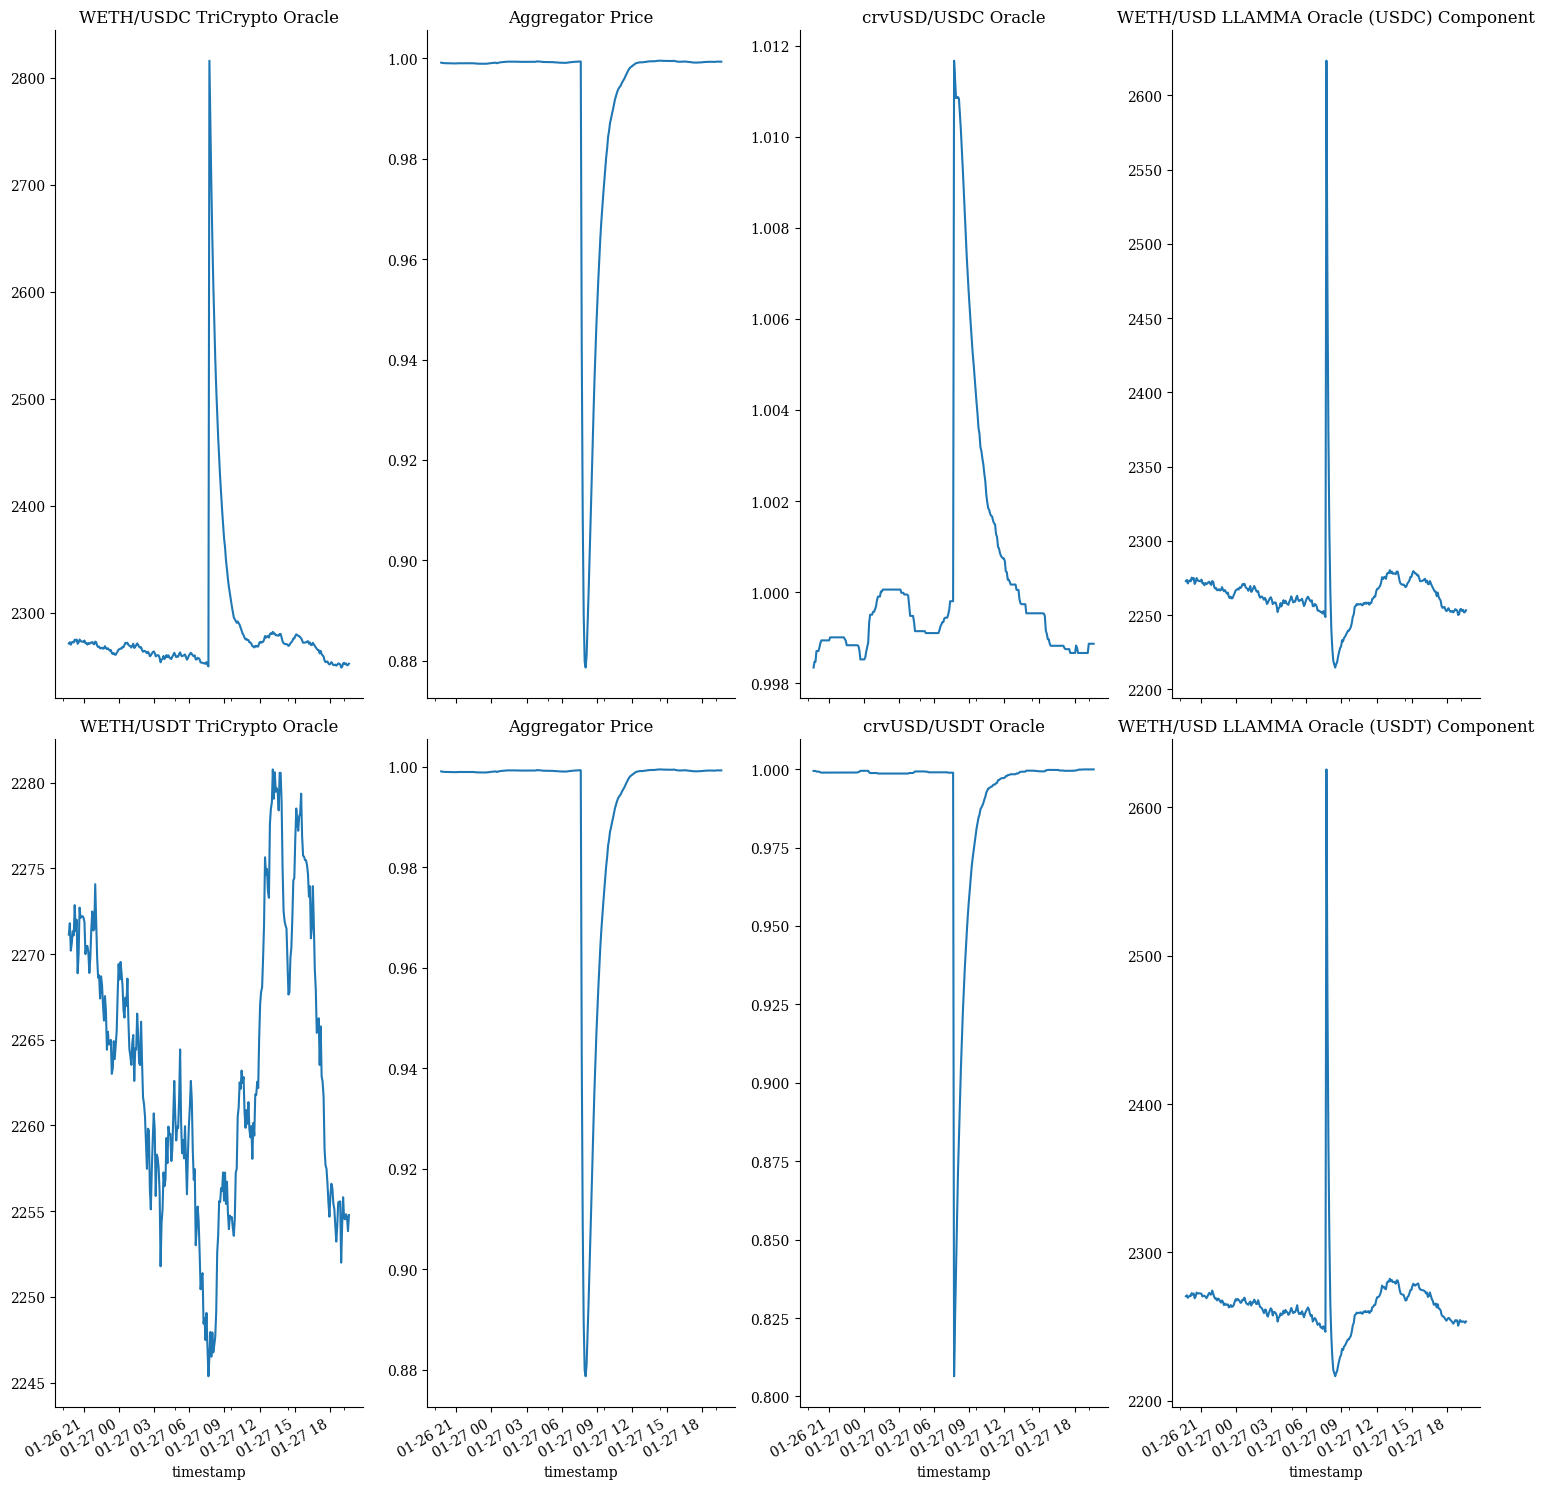

In [30]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2, 4, figsize=(15, 15), sharex=True)

# USDC
ax = axs[0, 0]
results.df["Tricrypto Usdc Oracle Price WETH"].plot(ax=ax)
ax.set_title("WETH/USDC TriCrypto Oracle")
ax = axs[0, 1]
results.df["Aggregator Price"].plot(ax=ax)
ax.set_title("Aggregator Price")
ax = axs[0, 2]
results.df["Stableswap Crvusd_Usdc Price"].plot(ax=ax)
ax.set_title("crvUSD/USDC Oracle")
ax = axs[0, 3]
ax.set_title("WETH/USD LLAMMA Oracle (USDC) Component")
(
    results.df["Tricrypto Usdc Oracle Price WETH"]
    * results.df["Aggregator Price"]
    / results.df["Stableswap Crvusd_Usdc Price"]
).plot(ax=ax)

ax = axs[1, 0]
results.df["Tricrypto Usdt Oracle Price WETH"].plot(ax=ax)
ax.set_title("WETH/USDT TriCrypto Oracle")
ax = axs[1, 1]
results.df["Aggregator Price"].plot(ax=ax)
ax.set_title("Aggregator Price")
ax = axs[1, 2]
results.df["Stableswap Crvusd_Usdt Price"].plot(ax=ax)
ax.set_title("crvUSD/USDT Oracle")
ax = axs[1, 3]
ax.set_title("WETH/USD LLAMMA Oracle (USDT) Component")
(
    results.df["Tricrypto Usdt Oracle Price WETH"]
    * results.df["Aggregator Price"]
    / results.df["Stableswap Crvusd_Usdt Price"]
).plot(ax=ax)

plt.tight_layout()
plt.show()

<Axes: xlabel='timestamp'>

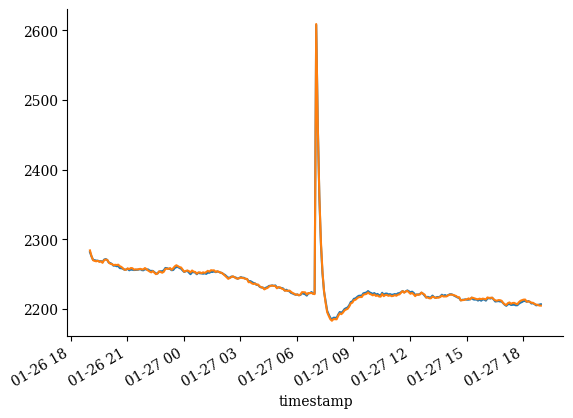

In [ ]:
(
    results.df["Tricrypto Tricryptousdt Oracle Price WETH"]
    * results.df["Aggregator Price"]
    / results.df["Stableswap Crvusd_Usdt Price"]
).plot()
(
    results.df["Tricrypto Tricryptousdc Oracle Price WETH"]
    * results.df["Aggregator Price"]
    / results.df["Stableswap Crvusd_Usdc Price"]
).plot()

<Axes: xlabel='timestamp'>

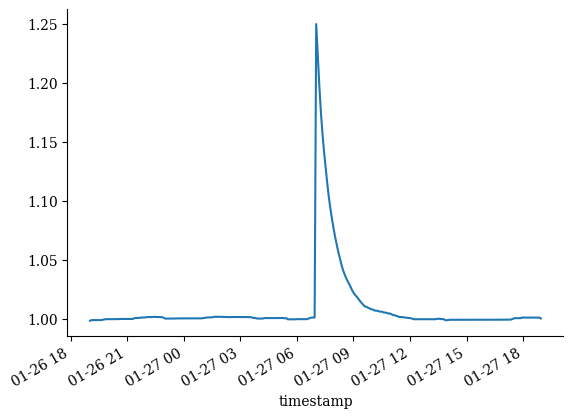

In [ ]:
(
    results.df["Stableswap Crvusd_Usdc Price"]
    / results.df["Stableswap Crvusd_Usdt Price"]
).plot()

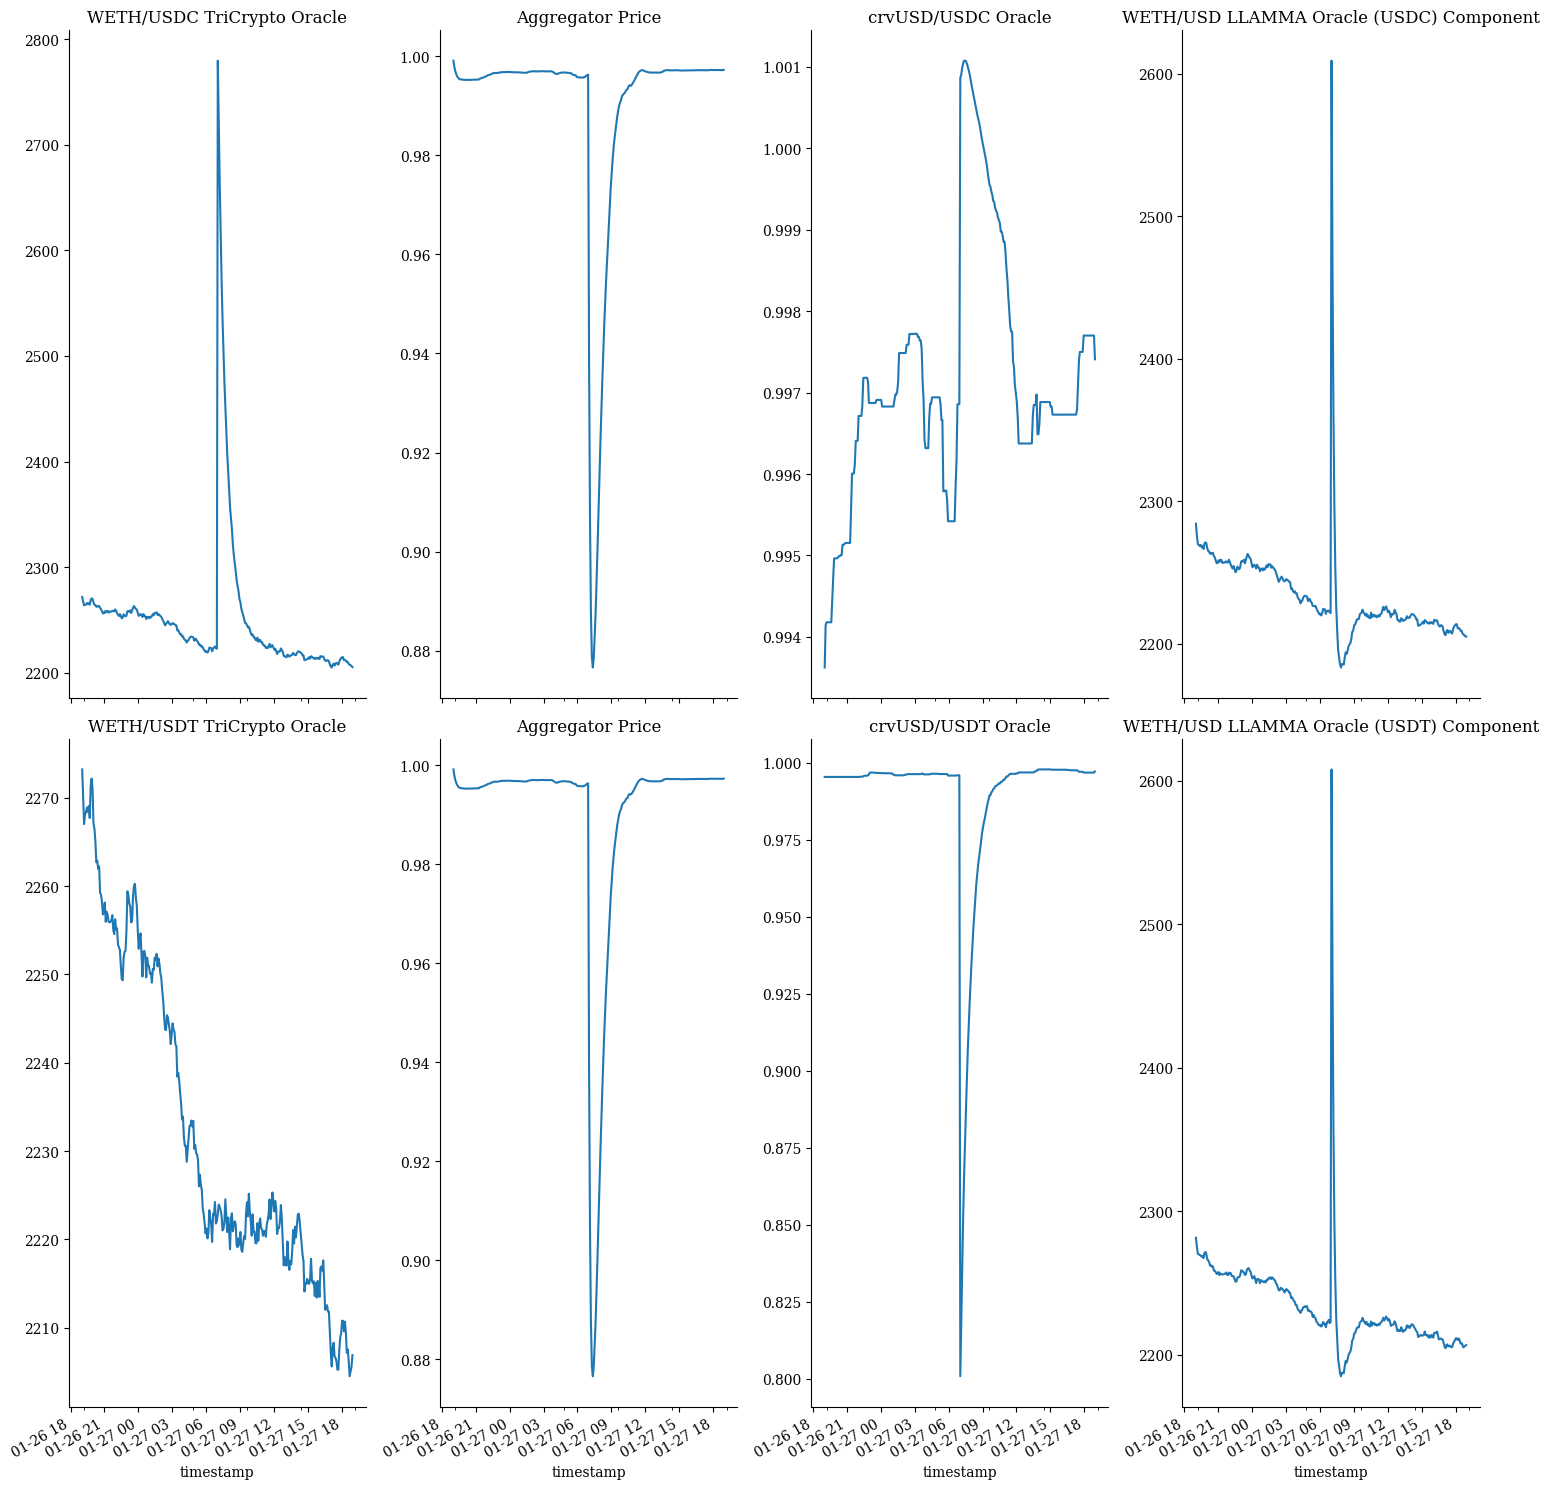

In [ ]:
ax.figure